# Lab Assignment 2

**Submission deadline:**
* **lab session in the week 22-27.11.20**

**Points: 18 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [2]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import graphviz
import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [3p] Ridge Regression

In this problem you will implement ridge regression **without using `sklearn`**!

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 + \frac{\alpha}{N} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:
1. $x \propto U(0;1)$: first $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$


## Task 1.1 [1.5p]
Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\alpha$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\alpha$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for alpha on the test set, **explain** the model behavoir for small alphas and large alphas.

## Task 1.2 [0.5p]
Use a small alpha for numerical stability (1e-6) and train the model on increasingly large training sets. Plot the training curves (train and test error rates versus amount of training data). What can you notice?

## Task 1.3 [1p]

Now let's change the data slightly:
1. $x \propto U(0;10)$
2. $y \propto \mathcal{N}(\mu=1+0.2x-0.05x^2 + 0.004x^3, \sigma=0.1)$

Try fitting the polynomial regression once again. Would it make sense to normalize the data after feature expansion?

Which dataset is easier to fit? When is ridge regression most effective? 

Note: in real life, we may e.g. have a dataset with mixed units, like milimeters and kilometers. Data normalization is often an important preprocessing step.


## Task 1.1

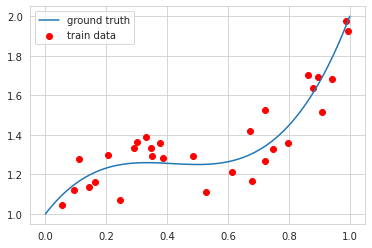

In [179]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#


def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1)  # len(Theta) x N
    Y = XP @ Theta.reshape((-1, 1))
    return Y


true_poly_theta = np.array([1.0, 2.0, -5, 4])

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1))
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y


train_data = make_dataset(30)
XX = np.linspace(0, 1, 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

$
    \Theta = (X^T X + \alpha I) ^{-1} X^T Y 
$

In [178]:
def poly_fit(data, degree, alpha):
    "Fit a polynomial of a given degree and weight decay parameter alpha"
    X = powers_of_X(data[0], degree)  # Matrix N x d
    Y = data[1].reshape(-1, 1)  # Matrix N x 1
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.linalg.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    #
    xtx = X.T @ X
    to_inv = X.T @ X + alpha * np.identity(len(xtx))
    # Theta = np.linalg.inv(to_inv) @ X.T @ Y
    Theta = np.linalg.solve(to_inv, X.T @ Y)
    return Theta

In [188]:
num_test_samples = 100
num_train_samples = [30]
alphas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
test_data_X, test_data_Y = make_dataset(num_test_samples)
results = []

test_better_count = 0

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data_X, train_data_Y = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, alpha)
    train_err = np.sum((compute_polynomial(train_data_X, Theta) - train_data_Y)**2)/30
    indexes = np.random.choice(a=num_test_samples, size=num_train)
    test_err = np.sum((compute_polynomial(test_data_X, Theta) - test_data_Y)**2)/100

    if (test_err < train_err): test_better_count += 1
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )

print(test_better_count)
results_df = pd.DataFrame(results)
results_df

993


,repetition,num_train,alpha,degree,dataset,err_rate
0,0,30,0.0,0,train,0.057285
1,0,30,0.0,0,test,0.048941
2,0,30,0.0,1,train,0.026157
3,0,30,0.0,1,test,0.021208
4,0,30,0.0,2,train,0.019049
...,...,...,...,...,...,...
7195,29,30,1.0,12,test,0.012882
7196,29,30,1.0,13,train,0.016398
7197,29,30,1.0,13,test,0.012913
7198,29,30,1.0,14,train,0.013644


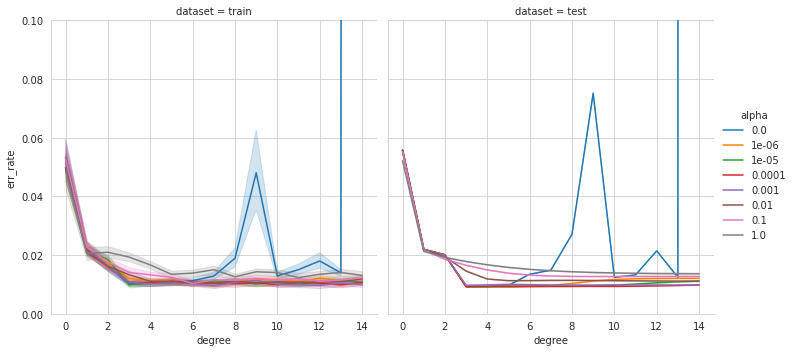

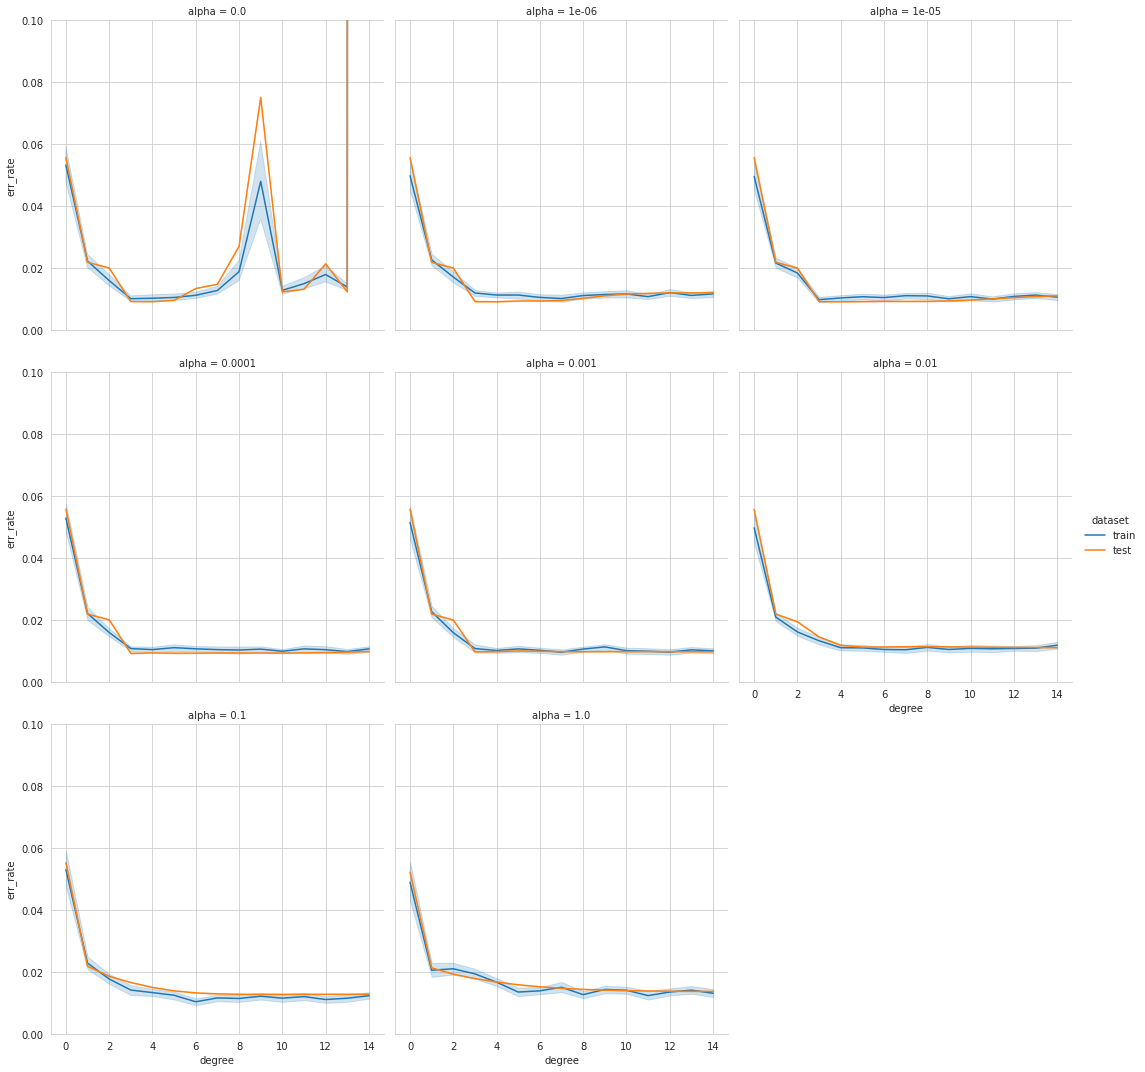

In [187]:
# TODO
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for lambda on the test set, explain the model
# behavoir for small lambdas and large lambdas.
#
# Hint: the plots below all use sns.relplot!
#

pal = sns.color_palette("tab10", n_colors=8)

plot = sns.relplot(data=results_df, col='dataset', x='degree', y='err_rate', hue='alpha', kind='line', legend=alphas, palette=pal)
plot.set(ylim=(0.0, 0.1))
plot

plot2 = sns.relplot(data=results_df, col='alpha', col_wrap=3, x='degree', y='err_rate', hue='dataset', kind='line', legend=alphas)
plot2.set(ylim=(0.0, 0.1))
plot2


**TODO**

Explain below the model behavoir for small alphas and large alphas.

For small alphas polynomial better fits the training set. For high-degree polynomials charts are more wavy - we have relatively big change of value with a little change of argument. Original/true polynomial's char is relatively flat on the interval (0,1), so points that are not very close to training points don't fit well. Bigger alphas make our chart more flat, fixing that problem. 




## Task 1.2

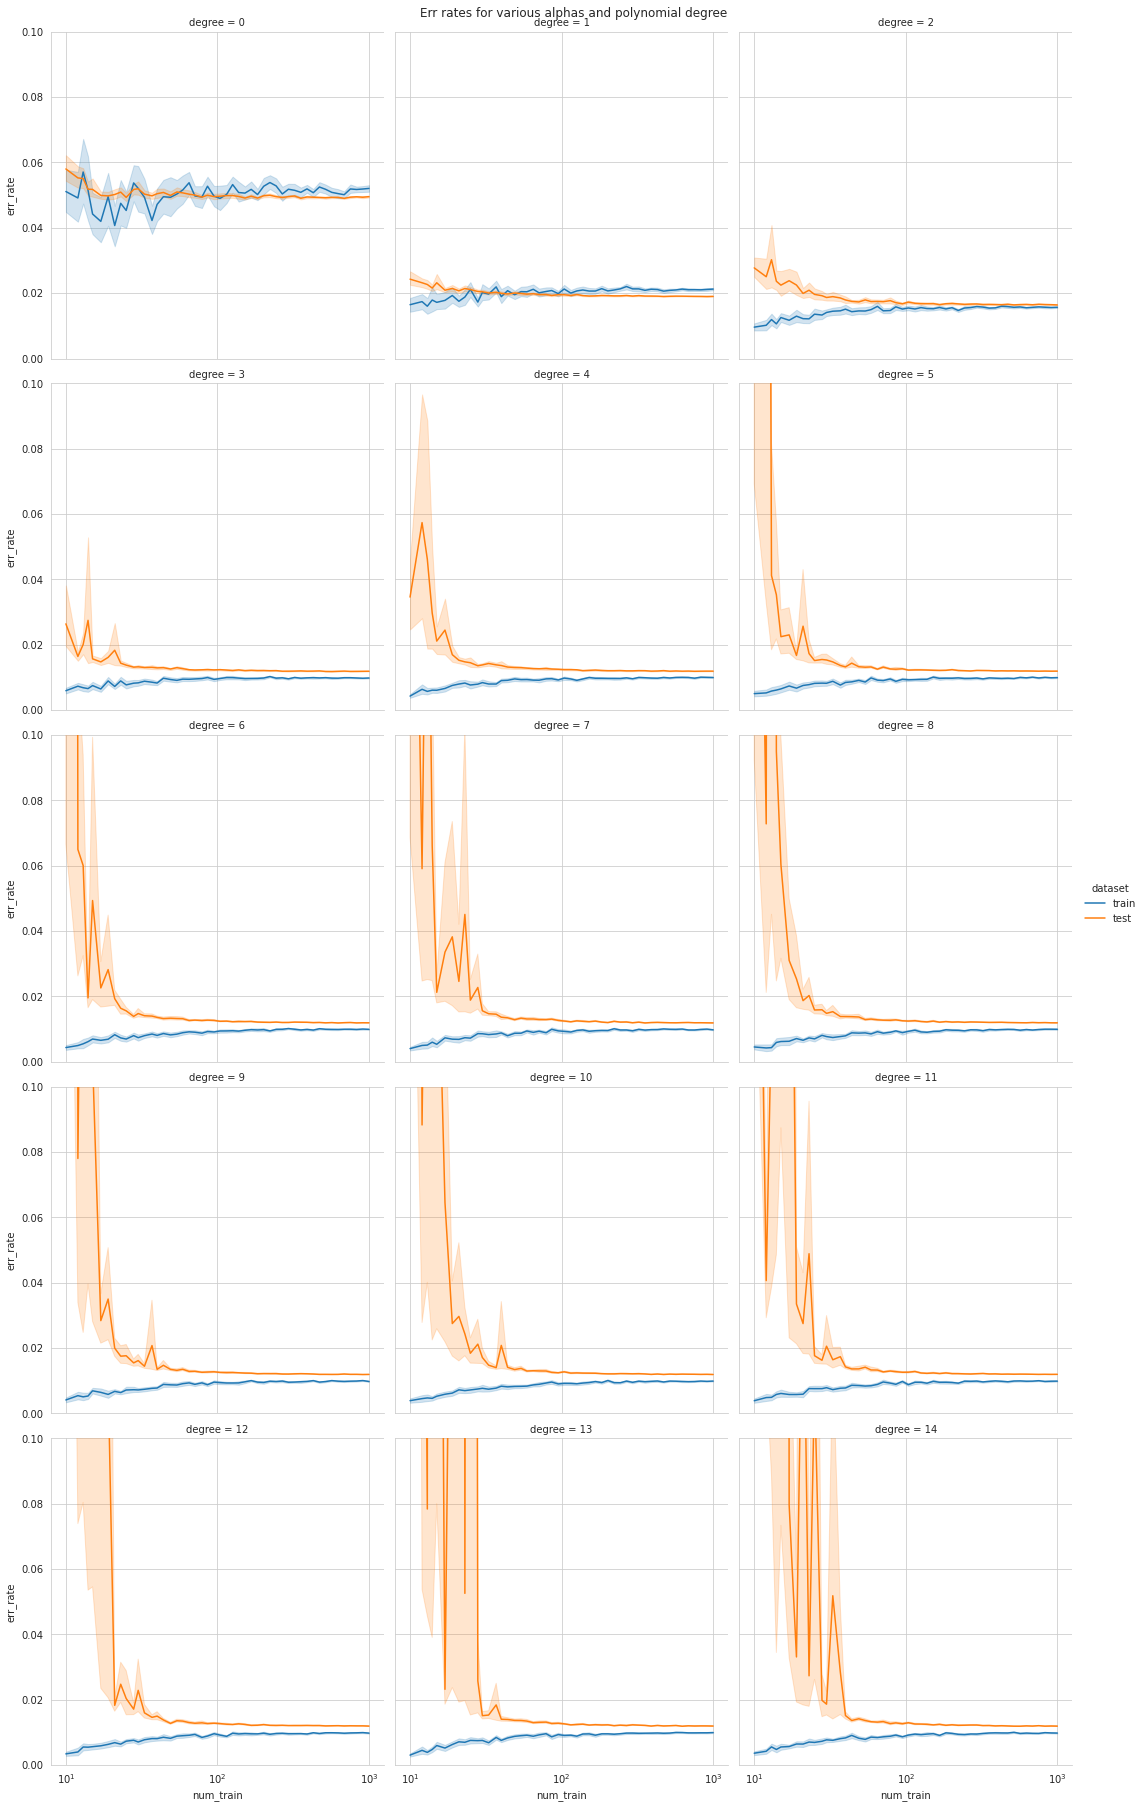

In [13]:
# TODO
# Now set a small regularizatoin for numerical stability  (e.g. alpha=1e-6)
# and present the relationship between
# train and test error rates for varous degrees of the polynomial for
# different sizes of the train set.
#


**TODO** Describe in two sentences the plot above. What can you notice?

## Task 1.3



In [1]:
# TODO: solve Task 1.3

**TODO** Answer below the questions:

Would it make sense to normalize the data after feature expansion?

Which dataset is easier to fit?

When is ridge regression most effective?

# Problem 2 (Logistic Regression) [2p]

Linear regression is suitable for problems, where
the forecasted values are real numbers. We use logistic regression,
when we want to label the data with $0$ and $1$.

Let $x\in \mathbb{R}^n$ be a row vector of $n$ real numbers, and
$y\in \{0,1\}$ the given class label. Similarly to what was shown
during the lecture, we add an additional element $x_0=1$
to vector $x$, to account for the bias term (and simplify the equations).

Similarly to linear regression, vector
$\Theta\in \mathbb{R}^{n+1}$ parametrizes the model
($n$ coefficients describes the data, the remaining one is the intercept).
In logistic regression, we model conditional probability that
sample $x$ belongs to class $1$ as:

\begin{equation}
p(\text{class}=1|x, \Theta)=h_\Theta(x) = \sigma\left(\sum_{j=0}^n  x_j\Theta_j\right) 
= \sigma\left(x\Theta \right),
\end{equation}

where $\sigma(a) = \frac{1}{1+\exp(-a)}$ is being called the logistic sigmoid
(a function, which plot is s-curved).

An unknown sample $x$ is being labeled $1$ if
$h_\Theta(x)\geq 0.5$, or equivalently, $x\Theta \geq 0$.

Classification mismatch between the forecasted values and
the data is being measured most of the time with cross-entropy:

\begin{equation}
    J(\Theta) = - \sum_{i=1}^m y^{(i)} \log \left(h_\Theta (x^{(i)})\right) + (1-y^{(i)}) \log \left(1-h_\Theta (x^{(i)})\right),
\end{equation}

assuming $0\log(0)=0$.


## Task 2.1 [1p]
Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use **L-BFGS** to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

## Task 2.2 [1p]
Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use **Gradient Descent** to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

## Task 2.3 [1p]

In an analogy to Ridge Regression, implement a penalty on the weights of logistic regression. 

Then make a contour plot of the probability assigned by the model with no regularization $\alpha=0$ and with regularization, e.g. $\alpha=10^-2$ and $\alpha=1$. Describe what has changed?

## Task 2.1 solution

In [21]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Targets: ", iris.target_names)
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

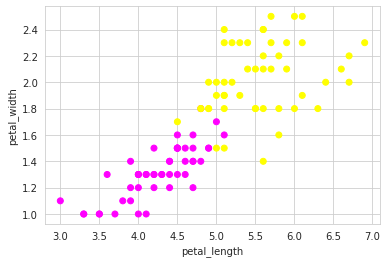

In [22]:
# Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[iris.target != 0, :]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target != 0] - 1).reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

(2.805, 7.095000000000001)

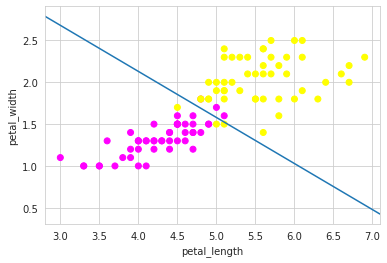

In [23]:
def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    # reshape Theta into a column vector - lBFGS gives us a flat array
    ThetaR = Theta.reshape(X.shape[1], 1)

    nll = TODO
    grad = TODO

    # reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)


Theta0 = np.zeros((3, ))

#
# Call a solver
#
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: logreg_loss(Theta, IrisX, IrisY), np.array(Theta0)
)[0]


#
# Now plot the found separation line
#

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
plt.xlim(pl_min, pl_max)

## Task 2.2 solution

(2.805, 7.095000000000001)

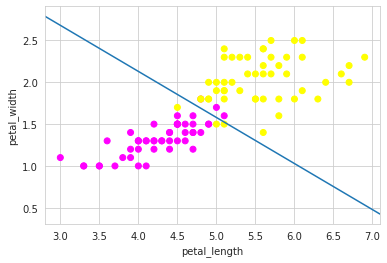

In [23]:
def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    # reshape Theta into a column vector - lBFGS gives us a flat array
    ThetaR = Theta.reshape(X.shape[1], 1)

    nll = TODO
    grad = TODO

    # reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)


Theta0 = np.zeros((3, ))

#
# in a loop perform the update Theta(t+1) = Theta(t) - lambda* d logreg_loss(Theta(t))/d Theta(t) 
# until no significant change is possible
#

TODO

#
# Now plot the found separation line
#

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
plt.xlim(pl_min, pl_max)

## Task 2.3 solution

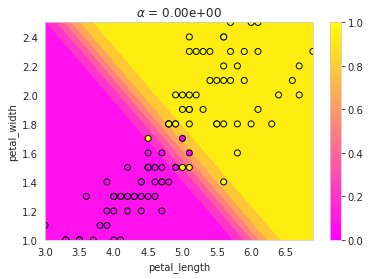

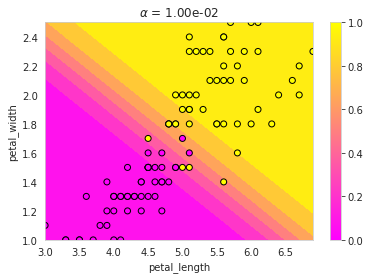

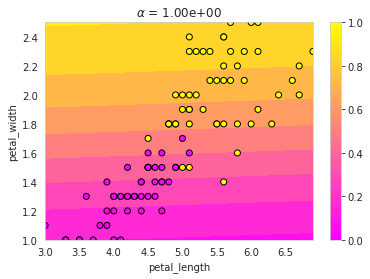

In [24]:
# Change logistic regression to include a weight penalty term as in ridge regression
# Then plot the probabilities for different values of alpha
# Hint: use the contour plot code from Assignent 1
alphas = [0, 1e-2, 1.0]


def logreg_loss_with_reg(Theta, X, Y, alpha=0.):
    #
    # Copy the logistic regression code and extend it with L2 regularization
    #
    TODO


mesh_x, mesh_y = np.meshgrid(
    np.linspace(IrisX[:, 1].min(), IrisX[:, 1].max(), 100),
    np.linspace(IrisX[:, 2].min(), IrisX[:, 2].max(), 100),
)
mesh_data = np.hstack([np.ones(mesh_x.reshape(-1, 1).shape), mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

for alpha in alphas:
  Theta0 = np.zeros((3, ))

  #
  # Call a solver
  #
  ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
      lambda Theta: logreg_loss_with_reg(Theta, IrisX, IrisY, alpha=alpha), np.array(Theta0)
  )
  #n_iter.append(dic['nit'])

  #
  # Now calculate probabilities for mesh_data
  #
  probs = TODO

  #
  # Plot the decision boundary
  #
  plt.contourf(mesh_x, mesh_y, probs.reshape(mesh_x.shape), cmap='spring')
  plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring", linewidths=1, edgecolors='black')
  plt.colorbar()
  plt.xlabel("petal_length")
  plt.ylabel("petal_width")
  pl_min, pl_max = plt.xlim()
  plt.title(fr'$\alpha$ = {alpha:.2e}')
  plt.xlim(pl_min, pl_max)
  plt.show()

**TODO**: type here what has change with the change of $\alpha$.